In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [13]:
# %pip install pandas
# %pip install seaborn
# %pip install matplotlib
# %pip install sklearn
# %pip install opencv-python


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

# deep learning libraries
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
from keras.callbacks import CSVLogger, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

import os, sys

import matplotlib.image as mpimg
from re import sub

import cv2 as cv


In [2]:
directory_train = r'E:\capstone\Rice Diseases (Leaf Blast Classification)\train'
directory_validation = r'E:\capstone\Rice Diseases (Leaf Blast Classification)\val'

In [3]:
category_count = []

for root, dirs, files in os.walk(directory_train):
    for dir_path in dirs:
        category_count.append((dir_path, len(os.listdir(root+os.sep+dir_path))))

count_df = pd.DataFrame(category_count, columns=['Classes', 'Total_Images'])
count_df

,Classes,Total_Images
0,Browon Spot,4033
1,Healthy Leaf,4048
2,Invalid,3637
3,Leaf Blast,4037


In [4]:
BATCH_SIZE = 32
IMG_SIZE = 224 # image height , image width
Output_layer = len(os.listdir(directory_train))

In [5]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range=10, # rotation
    width_shift_range=0.2, # horizontal shift
    height_shift_range=0.2, # vertical shift
    zoom_range=0.2, # zoom
    brightness_range=[0.2,1.2]
)

train_generator = gen.flow_from_directory(
    directory = directory_train,
    color_mode="rgb",
    target_size = (IMG_SIZE,IMG_SIZE), # image height , image width
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)

validation_generator = gen.flow_from_directory(
    directory = directory_validation, 
    color_mode="rgb",
    target_size = (IMG_SIZE, IMG_SIZE), # image height , image width
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)

Found 15755 images belonging to 4 classes.
Found 3348 images belonging to 4 classes.


In [6]:
print("Version ", tf.__version__)
print("Eager mode:", tf.executing_eagerly())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Version  2.10.0
Eager mode: True
Num GPUs Available:  1


In [7]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model_InceptionResNetV2 = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE,IMG_SIZE,3)
)
base_model_InceptionResNetV2.trainable=False
# base_model_InceptionResNetV2.trainable=False

# model_InceptionResNetV2 = tf.keras.Sequential([
#     base_model_InceptionResNetV2,
#     tf.keras.layers.BatchNormalization(renorm=True),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(120, activation='softmax'),
#     tf.keras.layers.Dense(Output_layer, activation='softmax')
# ])
InceptionResNetV2_model_tmp = tf.keras.Sequential([
    base_model_InceptionResNetV2,
    tf.keras.layers.BatchNormalization(renorm=True),
#     tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',input_shape = (224,224,3)),
    tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', name = 'Conv2D_1'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(32,(3,3),activation = 'relu', name = 'Conv2D_2'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64,(3,3),activation = 'relu', name = 'Conv2D_3'),
#     tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation = 'relu', name = 'Dense_1'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256,activation = 'relu', name = 'Dense_2'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(Output_layer,activation = 'softmax', name = 'Dense_3')

],    name = 'Conv2D_Model')

In [8]:
InceptionResNetV2_model_tmp.summary()

Model: "Conv2D_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 5, 5, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 Dense_1 (Dense)             (None, 128)               196736    
                                                      

In [9]:
InceptionResNetV2_model_tmp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy','categorical_accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')
                      ])

# early = tf.keras.callbacks.EarlyStopping( patience=10,
#                                          min_delta=0.001,
#                                          restore_best_weights=True)

batch_size=8
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size


In [10]:
csv_logger = CSVLogger('training_400_2_50.log')
best_weights_file = '400_best_model.epoch{epoch:02d}-loss{val_loss:.3f}.hdf5'
checkpoint = ModelCheckpoint(best_weights_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


# fit model
history = InceptionResNetV2_model_tmp.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    callbacks=[csv_logger]
)

InceptionResNetV2_model_tmp.save("Proposed_InceptionResNetV2_Model_50_2.h5")

Epoch 1/50
1969/1969 [==============================] - 2842s 1s/step - loss: 0.3837 - accuracy: 0.8484 - categorical_accuracy: 0.8484 - precision: 0.9059 - recall: 0.7848 - val_loss: 0.4074 - val_accuracy: 0.8499 - val_categorical_accuracy: 0.8499 - val_precision: 0.8874 - val_recall: 0.7987
Epoch 2/50
1969/1969 [==============================] - 3179s 2s/step - loss: 0.2444 - accuracy: 0.9006 - categorical_accuracy: 0.9006 - precision: 0.9238 - recall: 0.8779 - val_loss: 0.3793 - val_accuracy: 0.8523 - val_categorical_accuracy: 0.8523 - val_precision: 0.8730 - val_recall: 0.8307
Epoch 3/50
1969/1969 [==============================] - 3005s 2s/step - loss: 0.2253 - accuracy: 0.9094 - categorical_accuracy: 0.9094 - precision: 0.9266 - recall: 0.8911 - val_loss: 0.3691 - val_accuracy: 0.8639 - val_categorical_accuracy: 0.8639 - val_precision: 0.8874 - val_recall: 0.8292
Epoch 4/50
1969/1969 [==============================] - 2701s 1s/step - loss: 0.2136 - accuracy: 0.9149 - categorical_

In [11]:
accuracy_score = InceptionResNetV2_model_tmp.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])


419/419 [==============================] - 347s 785ms/step - loss: 0.2913 - accuracy: 0.8976 - categorical_accuracy: 0.8976 - precision: 0.9084 - recall: 0.8856
[0.29131025075912476, 0.8975507616996765, 0.8975507616996765, 0.9083946347236633, 0.8856033682823181]
Accuracy: 89.7551%
Loss:  0.29131025075912476


In [ ]:
# InceptionResNetV2_model_tmp = load_model("./Proposed_InceptionResNetV2_Model_25.h5")

In [12]:
from keras.models import load_model
# from keras.preprocessing import image

def load_image(img_path, show=False):

    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_tensor = tf.keras.utils.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


In [13]:
target_names = validation_generator.class_indices
pred_values = []
actual_values = []
root = r"D:\Educational Materials\Datasets\Final Final hope so\Rice Diseases (Leaf Blast Classification)\val"
list_dir_1 = os.listdir(root)
for i in list_dir_1:
    path = root+ '\\' +i+'\\'
    list_dir_2 = os.listdir(path)
    print(i)
    for j in list_dir_2:
        img_path = path + "\\" + j
        new_image = load_image(img_path)

        # check prediction
        pred = InceptionResNetV2_model_tmp.predict(new_image)
        pred_values.append(np.argmax(pred))
        actual_values.append(target_names[i])

pred_values = np.array(pred_values)
actual_values = np.array(actual_values)


Browon Spot
1/1 [==============================] - 0s 113ms/step
Healthy Leaf
1/1 [==============================] - 0s 103ms/step
Invalid
1/1 [==============================] - 0s 80ms/step
Leaf Blast
1/1 [==============================] - 0s 84ms/step


In [14]:
validation_generator.class_indices

{'Browon Spot': 0, 'Healthy Leaf': 1, 'Invalid': 2, 'Leaf Blast': 3}

In [15]:
# Y_pred = InceptionResNetV2_model_tmp.predict_generator(validation_generator)
# y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(actual_values, pred_values))
print('Classification Report')
target_names = ['Browon Spot', 'Healthy Leaf','Invalid', 'Leaf Blast']
# target_names = os.listdir(directory_train)
print(classification_report(actual_values, pred_values, target_names=target_names))

Confusion Matrix
[[221  13   0  12]
 [ 12 260   0  24]
 [  2   0 154   0]
 [  9  37   0 180]]
Classification Report
              precision    recall  f1-score   support

 Browon Spot       0.91      0.90      0.90       246
Healthy Leaf       0.84      0.88      0.86       296
     Invalid       1.00      0.99      0.99       156
  Leaf Blast       0.83      0.80      0.81       226

    accuracy                           0.88       924
   macro avg       0.89      0.89      0.89       924
weighted avg       0.88      0.88      0.88       924



In [16]:
# store results
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9450054168701172 \nValidation Accuracy: 0.9037081599235535')

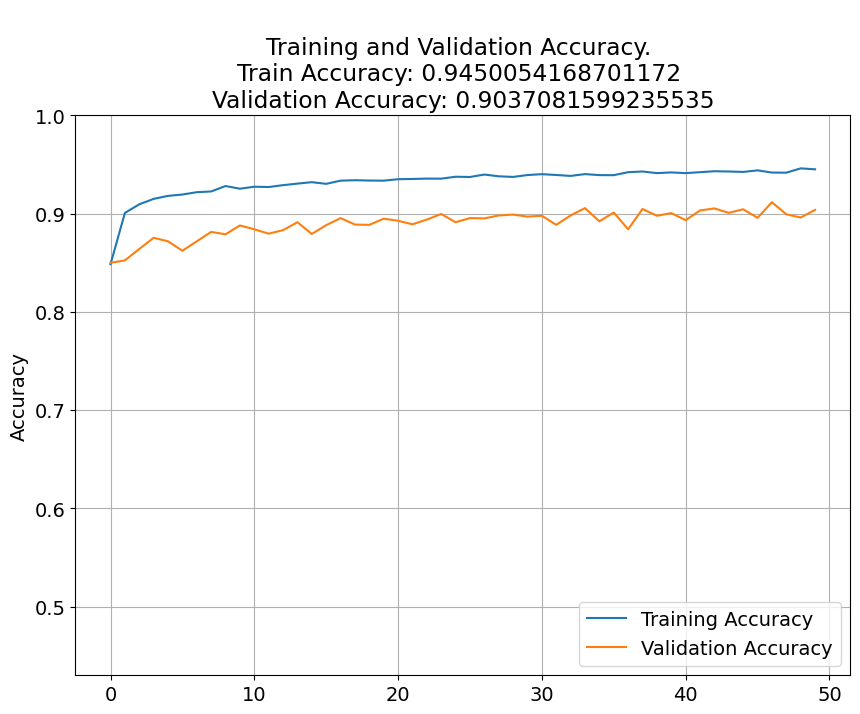

In [17]:
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.43,1.0])
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {(str(acc[-1]))} \nValidation Accuracy: {str(val_acc[-1])}')

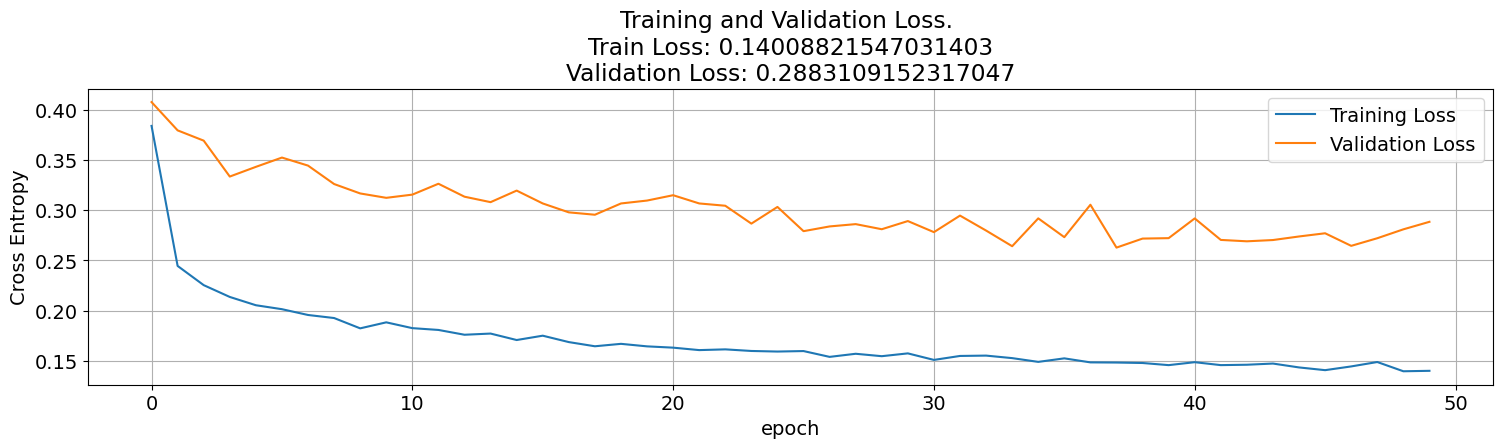

In [18]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

(224, 224)
(331, 331)


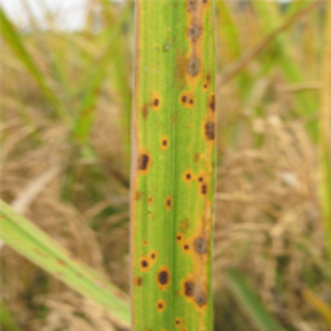

In [ ]:
from PIL import Image


image = Image.open(r'D:\Educational Materials\Datasets\Final Final hope so\brownspot_1.jpg').resize( ( 224, 224) ).convert( 'RGB')
print(image.size)
image = image.resize( ( 331, 331) )
print(image.size)
image 